<a href="https://www.kaggle.com/code/omarrehan0020/assignment-2?scriptVersionId=112559117" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import matplotlib.pyplot as plt


In [2]:
def loadVid(path):

    cap = cv2.VideoCapture(path)

    frames = []

    if cap.isOpened()== False:
        print("Error opening video stream or file")

    while(cap.isOpened()):

        ret, frame = cap.read()

        if ret:
            frames.append(frame)
        else:
            break

    cap.release()
    frames = np.stack(frames)

    return frames

In [3]:
def convert_to_grayscale(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

def convert_video_to_RGB(video):
    frames = []
    for f in video:
        frames.append(cv2.cvtColor(f, cv2.COLOR_BGR2RGB))
    return np.array(frames)

In [4]:
def detect(image1, image2):
    sift = cv2.SIFT_create()
    kp1, disc1 = sift.detectAndCompute(image1, None)
    kp2, disc2 = sift.detectAndCompute(image2, None)
    return kp1, disc1, kp2, disc2

def BF_FeatureMatcher(des1,des2):
    brute_force = cv2.BFMatcher()
    no_of_matches = brute_force.knnMatch(np.asarray(des1, np.float32), np.asarray(des2, np.float32), k=2)
 
    good = []
    for m,n in no_of_matches:
        if m.distance < 0.35 * n.distance:
            good.append([m])
            
    return good

In [5]:
def computeHomography(x1, x2):

    r = np.shape(x1)[0]
    A = []
    for i in range(r):
        xs = x1[i, 0, 0]
        ys = x1[i, 0, 1]
        
        xd = x2[i, 0, 0]
        yd = x2[i, 0, 1]
        
        r1 = [xs , ys , 1, 0, 0, 0, -xd * xs , -xd * ys , -xd]
        r2 = [ 0, 0, 0, xs , ys , 1, -yd * xs, -yd * ys  , -yd]
        A.append(r1)
        A.append(r2)

    A = np.asarray(A)
    u, s, vh = np.linalg.svd(A, full_matrices=True)
    
    ev = vh[-1,:]/vh[-1,-1] 
    homography = np.reshape(ev,(3,3))
    
    return homography

In [6]:
def plot_img(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# **Load Data**

(440, 350, 3)


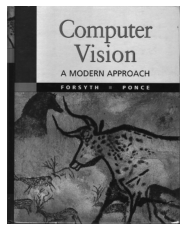

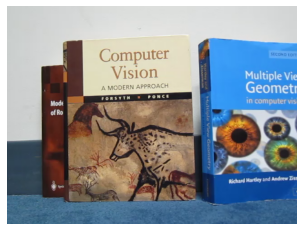

(641, 480, 640, 3)


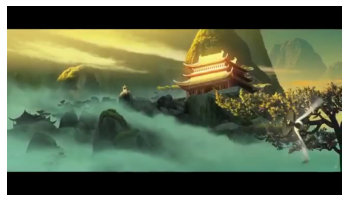

(511, 360, 640, 3)


In [7]:
cv_cover = cv2.imread("../input/homographies/cv_cover.jpg")
print(cv_cover.shape)

plot_img(cv_cover)

book_frames = loadVid("../input/homographies/book.mov")
book_frames = convert_video_to_RGB(book_frames)
plot_img(book_frames[0])
print(book_frames.shape)

movie_frames = loadVid("../input/homographies/ar_source.mov")
movie_frames = convert_video_to_RGB(movie_frames)
plot_img(movie_frames[0])
print(movie_frames.shape)

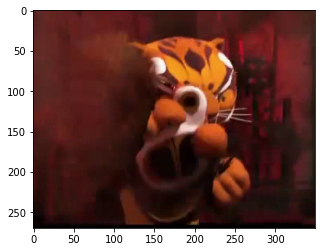

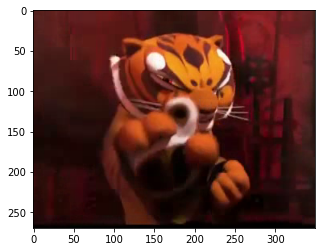

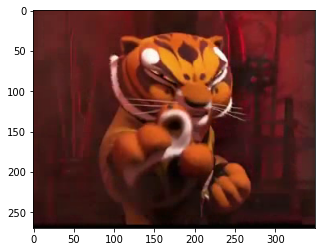

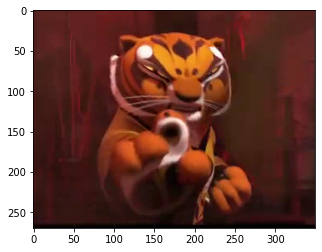

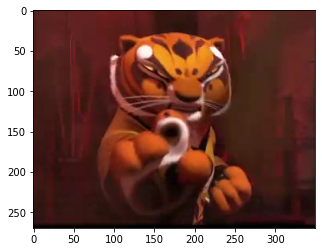

In [8]:
movie_frames = movie_frames[:,50:320,130:480,:]

for i in range(100, 105):
    plt.imshow(movie_frames[i])
    plt.show()

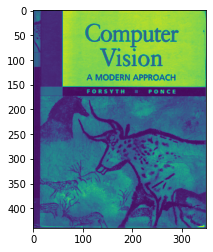

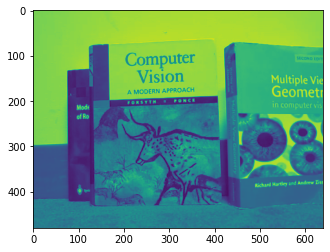

In [9]:
img1 = cv_cover
img2 = book_frames[1]


gray1= convert_to_grayscale(img1)
gray2= convert_to_grayscale(img2)


plt.imshow(gray1)
plt.show()
plt.imshow(gray2)
plt.show()

In [10]:
kp1, disc1, kp2, disc2 = detect(gray1, gray2)

kp1 = np.array(kp1)
disc1 = np.array(disc1)
kp2 = np.array(kp2)
disc2 = np.array(disc2)
# print(kp.shape)
print(kp1.shape)
print(disc1.shape)
print(kp2.shape)
print(disc2.shape)

(1205,)
(1205, 128)
(1780,)
(1780, 128)


(192, 1)


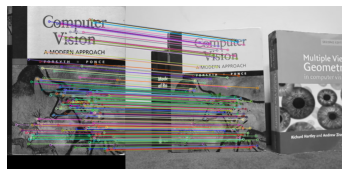

In [11]:
good = BF_FeatureMatcher(disc1,disc2)

good = np.array(good)
# good.reshape(good.shape[0],1)
print(good.shape)

img3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,good,None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img3)
plt.axis('off')
plt.show()

In [12]:
def get_matchings(book_frame):
    gray1= convert_to_grayscale(cv_cover)
    gray2= convert_to_grayscale(book_frame)
    kp1, disc1, kp2, disc2 = detect(gray1, gray2)
    good = BF_FeatureMatcher(disc1,disc2)
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    return src_pts, dst_pts

In [13]:
def compositeH(H2to1, template, img):
    
    #Create a composite image after warping the template image on top
    #of the image using the homography

    #Note that the homography we compute is from the image to the template;
    #x_template = H2to1*x_photo
    #For warping the template to the image, we need to invert it.
    

    #Create mask of same size as template
    mask_template = np.ones((template.shape[0], template.shape[1]), dtype=np.uint8)
    mask_img = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    
    #Warp template by appropriate homography
    composite_img = cv2.warpPerspective(template, H2to1, (img.shape[1], img.shape[0]), True)  # size (width,height) not (height, width) 
    #plt.imshow(composite_img)
    
    mask_temp_warp = cv2.warpPerspective(mask_template, H2to1, (img.shape[1], img.shape[0]), True)
    #print(mask_temp_warp.shape) ### 480 640
    #print(mask_temp_warp) ##white box on black (0)
    
    warp_not = cv2.bitwise_not(mask_temp_warp)//255
    warp_not = np.stack([warp_not,warp_not,warp_not])
    warp_not = np.transpose(warp_not, (1,2,0))
    
    background = img*warp_not
    composite_img = background + composite_img
    
    return composite_img

In [14]:
def draw_border(book_frame, H):
    h,w,_ = cv_cover.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,H) # just multiply corners with homogrphy and then normalize
    # print(dst)
    # print(pts.shape)
    # print(pts)
    # print(np.dot(M, [0, 0, 1]) / np.dot(M, [0, 0, 1])[-1])
    # print(np.dot(M, [0, 439, 1]) / np.dot(M, [0, 439, 1])[-1])
    # print(np.dot(M, [349, 439, 1]) / np.dot(M, [349, 439, 1])[-1])
    # print(np.dot(M, [349, 0, 1]))
    book_frame = cv2.polylines(book_frame,[np.int32(dst)],True,255,3, cv2.LINE_AA) # draw a rectangle arround the book in the dest img

In [15]:
src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)

In [16]:
print(src_pts.shape)
# print(src_pts)
# src_pts.reshape([src_pts.shape[0], 2])
# print(src_pts)
print(dst_pts.shape)

vvv = computeHomography(src_pts, dst_pts)

print(vvv.shape)

print(vvv)

print("\n\n")

## JUST TO MAKE SURE THAT OUR H IS THE SAME AS THE BUILT IN 

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
print(M)

(192, 1, 2)
(192, 1, 2)
(3, 3)
[[ 7.80964303e-01  4.54376505e-03  1.18788552e+02]
 [-4.73667829e-02  7.83177066e-01  7.67775312e+01]
 [-7.77013406e-05 -6.94583852e-05  1.00000000e+00]]



[[ 7.81557445e-01  4.79133906e-03  1.18731341e+02]
 [-4.69505681e-02  7.83660051e-01  7.66974761e+01]
 [-7.65641683e-05 -6.87359480e-05  1.00000000e+00]]


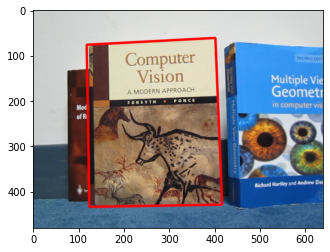

In [17]:
h,w,_ = img1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M) # just multiply corners with homogrphy and then normalize
# print(dst)
# print(pts.shape)
# print(pts)
# print(np.dot(M, [0, 0, 1]) / np.dot(M, [0, 0, 1])[-1])
# print(np.dot(M, [0, 439, 1]) / np.dot(M, [0, 439, 1])[-1])
# print(np.dot(M, [349, 439, 1]) / np.dot(M, [349, 439, 1])[-1])
# print(np.dot(M, [349, 0, 1]))
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA) # draw a rectangle arround the book in the dest img
plt.imshow(img2)
plt.show()

In [18]:
def is_valid(i, j, rows, cols):
    return i >= 0 and i < rows and j >= 0 and j < cols

(220, 220, 3)


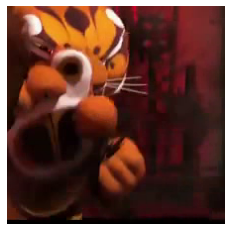

(363, 220, 3)


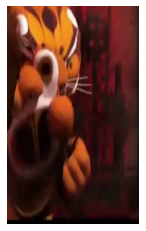

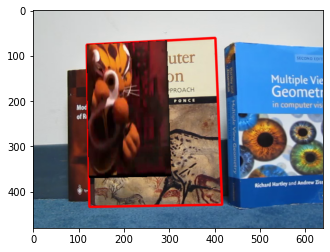

In [19]:
mov = movie_frames[100]
temp = img2.copy()


u = movie_frames.copy()
u = u[:,50:320,130:480,:]
print(u[100].shape)
plt.imshow(u[100])
plt.axis('off')
plt.show()


bb = cv2.resize(u[100], (0, 0), fx=1, fy=1.65)
print(bb.shape)
plt.imshow(bb)
plt.axis('off')
plt.show()

imm = compositeH(vvv, bb, img2) 
plt.imshow(imm)
plt.show()


In [20]:
output_frames = []
video = cv2.VideoWriter("/kaggle/working/out.avi", cv2.VideoWriter_fourcc('M','J','P','G'), 30, (book_frames.shape[2],book_frames.shape[1]))

for idx, mov_frame in enumerate(movie_frames):
    mov_frame = cv2.resize(mov_frame, (0, 0), fx=1, fy=1.65)
    book_frame = book_frames[idx]
    src_pts, dst_pts = get_matchings(book_frame)
    H = computeHomography(src_pts, dst_pts)
#     H = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    #H, mask = np.array(H)
    draw_border(book_frame, H)
    new_frame = compositeH(H, mov_frame, book_frame)
    video.write(cv2.cvtColor(new_frame, cv2.COLOR_RGB2BGR))
    #     plot_img(new_frame)

video.release()
    


In [21]:
from math import inf, ceil, floor
def point(y, x):
    return np.array([x,y,1]).reshape((3, 1))

def transform(point,H):
    P = H @ point
    P = P / P[2]
    return P

def warpPerspective(img, H):
  # note the first index of image is y
    height = img.shape[0]
    width = img.shape[1]

    boundaries = np.array([[0,0],[height-1, 0],[0, width-1],[height-1, width-1]])
    minX, minY, maxX, maxY = (inf, inf, -inf, -inf)
    for b in boundaries:
        P = transform(point(b[0],b[1]),H)
        minX, minY = (min(minX, P[0].item()), min(minY, P[1].item()))
        maxX, maxY = (max(maxX, P[0].item()), max(maxY, P[1].item()))

    warpedImg = np.zeros((ceil(maxY - minY), ceil(maxX - minX), 3), dtype=np.uint8)
    for y in range(img.shape[0]):
         for x in range(img.shape[1]):
            P = transform(point(y,x),H)
            warpedImg[int(P[1] - minY), int(P[0] - minX)] = img[y, x]
  
    shiftX,shiftY=minX,minY
    return warpedImg,shiftX,shiftY

In [22]:
def Bilinear_interpolation(img, x, y):
    h, w, _ = img.shape
    minY, maxY = (floor(y), ceil(y))
    minX, maxX = (floor(x), ceil(x))

    result = 0

    if minY >= 0 and minY < h and minX >= 0 and minX < w:
        result+= ((1 - abs(y - minY)) * (1 - abs(x - minX)) * img[minY,minX , :])
  
    if minY >= 0 and minY < h and maxX >= 0 and maxX < w:
        result+= ((1 - abs(y - minY)) * (1 - abs(x - maxX)) * img[minY,maxX , :])

    if maxY >= 0 and maxY < h and minX >= 0 and minX < w:
        result+= ((1 - abs(y - maxY)) * (1 - abs(x - minX)) * img[maxY,minX , :])

    if maxY >= 0 and maxY < h and maxX >= 0 and maxX < w:
        result+= ((1 - abs(y - maxY)) * (1 - abs(x - maxX)) * img[maxY,maxX , :])

    return result

In [23]:
def remove_holes(warpedImg,H,img,shiftX,shiftY):
    H_inv = np.linalg.inv(H)

    index =np.where(warpedImg[:,:,0]==0)
    for i in range(len(index[0])):
        y=index[0][i]
        x=index[1][i]
        P = transform(point( y + shiftY, x + shiftX),H_inv ) 
        P.reshape(-1)
        warpedImg[y, x, :] = Bilinear_interpolation(img, P[0], P[1])

    if warpedImg.shape[2] == 1:
        warpedImg = warpedImg.reshape(warpedImg.shape[0], -1)

    return warpedImg

In [24]:
def create_mosaic(left_image,right_image,shiftX,shiftY):
    plt.imshow(left_image)
    plt.show()
    
    wrap_shiftX,wrap_shiftY = max(0, round(shiftX)), max(0, round(shiftY))
    img_shiftX,img_shiftY = max(0, round(-shiftX)), max(0, round(-shiftY))
    
    height = max(wrap_shiftY+left_image.shape[0],img_shiftY+right_image.shape[0])
    width = img_shiftX+right_image.shape[1]
    output = np.zeros((height, width,3))  

    output[wrap_shiftY:wrap_shiftY+left_image.shape[0], wrap_shiftX:wrap_shiftX+left_image.shape[1]] = left_image
    output[img_shiftY:img_shiftY+right_image.shape[0], img_shiftX:img_shiftX+right_image.shape[1]] = right_image  


    output = output.astype(np.uint8)
    return output

In [25]:
def stitch_images(img1, img2):
    gray1= convert_to_grayscale(img1)
    gray2= convert_to_grayscale(img2)
    kp1, disc1, kp2, disc2 = detect(gray1, gray2)
    good = BF_FeatureMatcher(disc1,disc2)
    img3 = cv2.drawMatchesKnn(gray1,kp1,gray2,kp2,good,None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)
    plt.axis('off')
    plt.show()
    src_pts = np.float32([ kp1[m[0].queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m[0].trainIdx].pt for m in good ]).reshape(-1,1,2)
    H = computeHomography(src_pts, dst_pts)
    print(H)
    (wraped_image,shiftX,shiftY) = warpPerspective(img1,H)
    plt.imshow(wraped_image)
    plt.show()
    wraped_image=remove_holes(wraped_image,H,img1,shiftX,shiftY)
    
    result = create_mosaic(wraped_image ,img2, shiftX, shiftY)
    return result

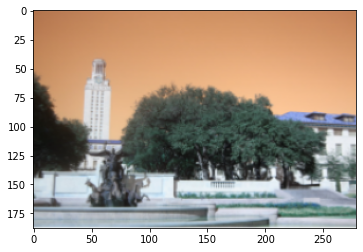

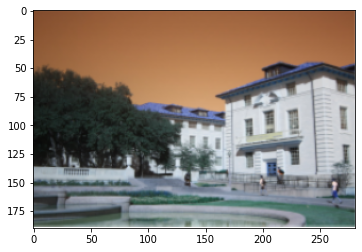

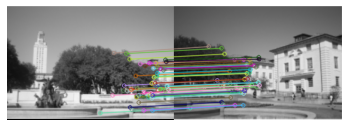

[[ 1.32410436e+00 -7.51565652e-02 -1.61178451e+02]
 [ 1.79424890e-01  1.23768806e+00 -4.81747703e+01]
 [ 1.07842623e-03  7.08963068e-05  1.00000000e+00]]


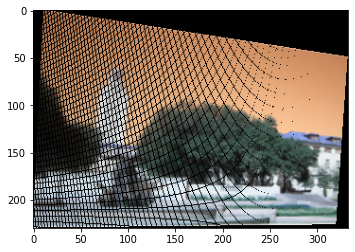

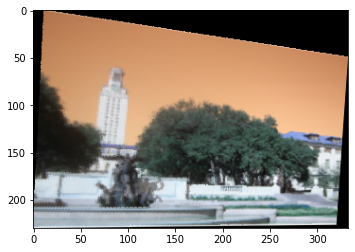

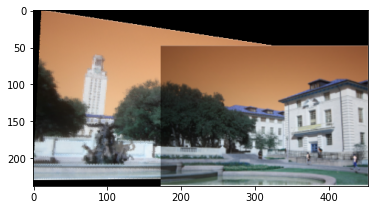

In [26]:
view1 = cv2.imread("../input/homographies/pic1.PNG")
plt.imshow(view1)
plt.show()
view2 = cv2.imread("../input/homographies/pic2.PNG")
plt.imshow(view2)
plt.show()
result = stitch_images(view1 , view2)
plt.imshow(result)
plt.show()

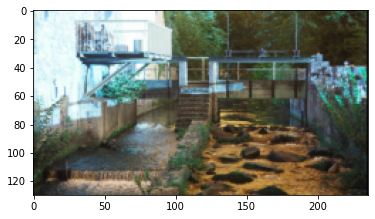

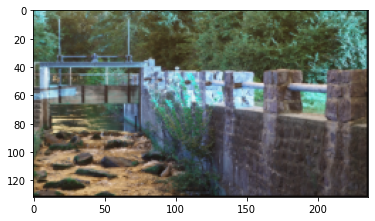

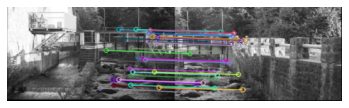

[[ 1.11685444e+00 -1.82630264e-03 -1.32773257e+02]
 [ 2.60988412e-02  1.08487185e+00  1.25074433e-01]
 [ 5.45996565e-04 -1.02697820e-04  1.00000000e+00]]


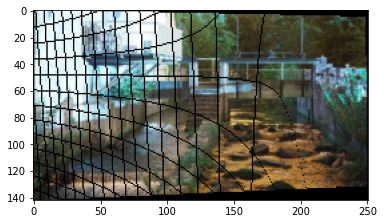

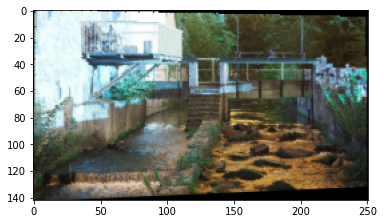

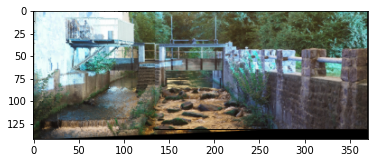

In [27]:
view1 = cv2.imread("../input/homographies/ex1.PNG")
plt.imshow(view1)
plt.show()
view2 = cv2.imread("../input/homographies/ex2.PNG")
plt.imshow(view2)
plt.show()
result = stitch_images(view1 , view2)
plt.imshow(result)
plt.show()

In [28]:
img_1 = cv2.imread("../input/homographies/view1.PNG")
img_2 = cv2.imread("../input/homographies/view2.PNG")
img_3 = cv2.imread("../input/homographies/view3.PNG")

print(img_1.shape)
print(img_2.shape)
print(img_3.shape)


(590, 390, 3)
(590, 393, 3)
(582, 391, 3)


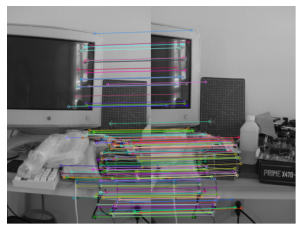

[[ 1.10715911e+00  6.68868625e-03 -1.44060580e+02]
 [ 5.64487456e-02  1.06976283e+00 -2.21197759e+01]
 [ 2.55312631e-04 -1.23480668e-05  1.00000000e+00]]


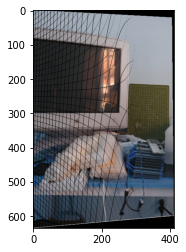

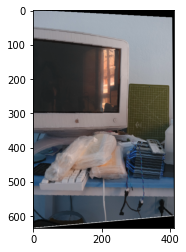

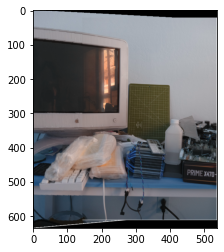

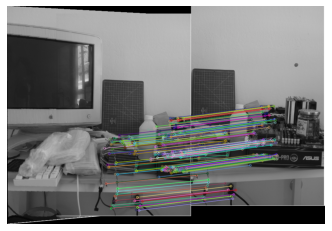

[[ 1.35961117e+00  5.17824961e-02 -3.99769418e+02]
 [ 1.31907261e-01  1.37311626e+00 -1.33172115e+02]
 [ 4.72567186e-04  2.10623384e-04  1.00000000e+00]]


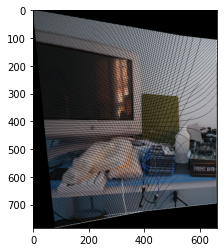

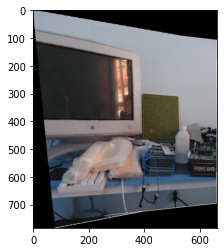

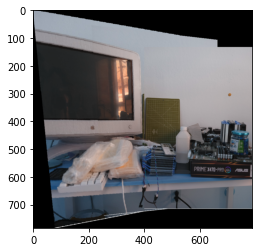

In [29]:
result = stitch_images(img_1 , img_2)
plt.imshow(result)
plt.show()
result = stitch_images(result , img_3)
plt.imshow(result)
plt.show()